In [1150]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from sklearn.linear_model import SGDRegressor



### Virtual valuation and Reserve price calculator

In [1151]:
class VirtualValuationCalculator:
    def virtual_valuation(self, v, mean, stddev):
        f_cdf = norm.cdf(v, loc=mean, scale=stddev)
        f_pdf = norm.pdf(v, loc=mean, scale=stddev)
        return v - (1 - f_cdf) / f_pdf
    
    def phi_inverse_v(self, v, mean, stddev):
        """Find the bid corresponding to the given virtual valuation (v)."""
        def phi(bid):
            return self.virtual_valuation(bid, mean, stddev) - v  # Adjusted for the virtual valuation
        
        # Check if phi has opposite signs at the bounds
        v_low = mean - 10 * stddev
        v_high = mean + 10 * stddev

        # Calculate the function at the bounds
        f_low = phi(v_low)
        f_high = phi(v_high)
        
        # Ensure that the bounds contain a sign change
        if f_low * f_high > 0:
            raise ValueError(f"Function values at bounds do not have opposite signs: f(v_low) = {f_low}, f(v_high) = {f_high}")

        # Find the root
        bid = brentq(phi, v_low, v_high)
        return bid


class ReservePriceCalculator(VirtualValuationCalculator):
    def __init__(self, means, stddevs):
        self.means = means
        self.stddevs = stddevs

    def phi_inverse_0(self, mean, stddev):
        def phi(v):
            return self.virtual_valuation(v, mean, stddev)  

        v_low = mean - 3 * stddev  # Lower bound for root-finding
        v_high = mean + 3 * stddev  # Upper bound for root-finding
        reserve_price = brentq(phi, v_low, v_high)
        
        return reserve_price

    def calculate_reserve_prices(self):
        reserve_prices = []
        for mean, stddev in zip(self.means, self.stddevs):
            r_star = self.phi_inverse_0(mean, stddev)
            reserve_prices.append(r_star)
        return reserve_prices
    

### Set up participant data

In [1152]:
# Example usage
np.random.seed(42)

# Simulating participants
num_participants = 10

true_means = np.random.uniform(50, 150, num_participants)  # True means of participants

initial_guess = 100 # Prior guess for every participant

est_means = np.full(num_participants, initial_guess) #array of these guesses which will be altered iteratively

# Store participant data
participants = {
    i: {
        "true_mean": true_means[i],
        "estimated_mean": est_means[i],
    }
    for i in range(num_participants)
}

In [1153]:
stddevs = np.full(num_participants, 5) # Fixed standard deviation of 5 for simplicity of model

### Update particpant information to include true reserve pricing

In [1154]:
# Initialize ReservePriceCalculator with true means and stddevs
calculator = ReservePriceCalculator(true_means, stddevs)

# Calculate reserve prices for all participants
true_reserve_prices = calculator.calculate_reserve_prices()

# Update participant data with true reserve prices
for i, reserve_price in enumerate(true_reserve_prices):
    participants[i]["true_reserve_price"] = reserve_price

# Print the results
for i, data in participants.items() :
    print(f"Participant {i+1}: {data}")


Participant 1: {'true_mean': 87.45401188473625, 'estimated_mean': 100, 'true_reserve_price': 77.82702917193446}
Participant 2: {'true_mean': 145.07143064099162, 'estimated_mean': 100, 'true_reserve_price': 134.15087322892364}
Participant 3: {'true_mean': 123.1993941811405, 'estimated_mean': 100, 'true_reserve_price': 112.67800408478666}
Participant 4: {'true_mean': 109.86584841970367, 'estimated_mean': 100, 'true_reserve_price': 99.6342731799071}
Participant 5: {'true_mean': 65.60186404424365, 'estimated_mean': 100, 'true_reserve_price': 56.79570493836255}
Participant 6: {'true_mean': 65.59945203362027, 'estimated_mean': 100, 'true_reserve_price': 56.7934025369315}
Participant 7: {'true_mean': 55.80836121681995, 'estimated_mean': 100, 'true_reserve_price': 47.496608820983724}
Participant 8: {'true_mean': 136.61761457749353, 'estimated_mean': 100, 'true_reserve_price': 125.84183888351781}
Participant 9: {'true_mean': 110.11150117432088, 'estimated_mean': 100, 'true_reserve_price': 99.87

### Include auctionner guess of reserve price per candidate

In [1155]:
# Initialize ReservePriceCalculator with estimated means and stddevs
est_calculator = ReservePriceCalculator(est_means, stddevs)

# Calculate reserve prices based on estimated means
est_reserve_prices = est_calculator.calculate_reserve_prices()

# Update participant data with estimated reserve prices
for i, est_reserve in enumerate(est_reserve_prices):
    participants[i]['Estimated_reserve_price'] = est_reserve

# Print the results
for i, data in participants.items():
    print(f"Participant {i+1}: {data}")
 

Participant 1: {'true_mean': 87.45401188473625, 'estimated_mean': 100, 'true_reserve_price': 77.82702917193446, 'Estimated_reserve_price': 90.01316311109564}
Participant 2: {'true_mean': 145.07143064099162, 'estimated_mean': 100, 'true_reserve_price': 134.15087322892364, 'Estimated_reserve_price': 90.01316311109564}
Participant 3: {'true_mean': 123.1993941811405, 'estimated_mean': 100, 'true_reserve_price': 112.67800408478666, 'Estimated_reserve_price': 90.01316311109564}
Participant 4: {'true_mean': 109.86584841970367, 'estimated_mean': 100, 'true_reserve_price': 99.6342731799071, 'Estimated_reserve_price': 90.01316311109564}
Participant 5: {'true_mean': 65.60186404424365, 'estimated_mean': 100, 'true_reserve_price': 56.79570493836255, 'Estimated_reserve_price': 90.01316311109564}
Participant 6: {'true_mean': 65.59945203362027, 'estimated_mean': 100, 'true_reserve_price': 56.7934025369315, 'Estimated_reserve_price': 90.01316311109564}
Participant 7: {'true_mean': 55.80836121681995, 'e

In [1156]:
for i, data in participants.items():
    print(f"Particpant {i+1}: {data['true_reserve_price'],data['Estimated_reserve_price']}")

Particpant 1: (77.82702917193446, 90.01316311109564)
Particpant 2: (134.15087322892364, 90.01316311109564)
Particpant 3: (112.67800408478666, 90.01316311109564)
Particpant 4: (99.6342731799071, 90.01316311109564)
Particpant 5: (56.79570493836255, 90.01316311109564)
Particpant 6: (56.7934025369315, 90.01316311109564)
Particpant 7: (47.496608820983724, 90.01316311109564)
Particpant 8: (125.84183888351781, 90.01316311109564)
Particpant 9: (99.87419136028916, 90.01316311109564)
Particpant 10: (110.33486965151856, 90.01316311109564)


In [1157]:
# After the auction ends, print the comparison of true and estimated means for each participant
for i in range(num_participants):
    print(f"Participant {i+1}: True Mean = {auction.true_means[i]}, Estimated Mean = {auction.est_means[i]}")

Participant 1: True Mean = 87.45401188473625, Estimated Mean = 62
Participant 2: True Mean = 145.07143064099162, Estimated Mean = 162
Participant 3: True Mean = 123.1993941811405, Estimated Mean = 169
Participant 4: True Mean = 109.86584841970367, Estimated Mean = 112
Participant 5: True Mean = 65.60186404424365, Estimated Mean = 49
Participant 6: True Mean = 65.59945203362027, Estimated Mean = 44
Participant 7: True Mean = 55.80836121681995, Estimated Mean = 64
Participant 8: True Mean = 136.61761457749353, Estimated Mean = 115
Participant 9: True Mean = 110.11150117432088, Estimated Mean = 156
Participant 10: True Mean = 120.80725777960456, Estimated Mean = 151


In [1158]:
class Auction:
    def __init__(self, num_participants, stddevs, true_means):
        self.num_participants = num_participants
        self.stddevs = stddevs  
        self.true_means = true_means
        self.est_means = np.full(num_participants, 100)  # Initial estimates
        self.t = 1

        # Initialize ReservePriceCalculator with true means and standard deviations to calculate true reserve prices
        self.true_reserve_price_calculator = ReservePriceCalculator(self.true_means, self.stddevs)
        self.true_reserve_prices = self.true_reserve_price_calculator.calculate_reserve_prices()

        # Initialize ReservePriceCalculator with estimated means and standard deviations to calculate estimated reserve prices
        self.reserve_price_calculator = ReservePriceCalculator(self.est_means, self.stddevs)

        # Store participants' data
        self.participants = {
            i: {
                'true_mean': true_means[i],
                'estimated_mean': self.est_means[i],
                'true_reserve_price': self.true_reserve_prices[i],  # Keep true reserve prices
                'Estimated_reserve_price': None,  # Will calculate this later based on estimated means
            }
            for i in range(num_participants)
        }

    def generate_bid(self, true_mean, stddev):
        """Generate a random bid based on true mean and standard deviation."""
        return norm.rvs(true_mean, stddev)

    def run_auction(self, round_number):
        """
        Run a single round of the auction and print all relevant information.
        """
        # Generate bids for all participants
        bids = [self.generate_bid(mean, stddev) for mean, stddev in zip(self.true_means, self.stddevs)]

        # Calculate estimated reserve prices based on estimated means (before updating)
        est_reserve_prices = self.reserve_price_calculator.calculate_reserve_prices()

        # Calculate virtual valuations using estimated means
        virtual_valuation_calculator = VirtualValuationCalculator()
        virtual_valuations_estimated = [
            virtual_valuation_calculator.virtual_valuation(bid, est_mean, stddev)
            for bid, est_mean, stddev in zip(bids, self.est_means, self.stddevs)
        ]

        # Calculate virtual valuations using true means (fully informed)
        virtual_valuations_true = [
            virtual_valuation_calculator.virtual_valuation(bid, true_mean, stddev)
            for bid, true_mean, stddev in zip(bids, self.true_means, self.stddevs)
        ]

        # --- ESTIMATED Virtual Valuation Case ---
        valid_virtual_valuations_estimated = [
            (v, idx) for idx, v in enumerate(virtual_valuations_estimated) if v > 0
        ]
        if valid_virtual_valuations_estimated:
            sorted_valuations_estimated = sorted(valid_virtual_valuations_estimated, key=lambda x: x[0], reverse=True)

            highest_virtual_valuation_estimated, highest_idx_estimated = sorted_valuations_estimated[0]

            # If there is a second-highest virtual valuation
            if len(sorted_valuations_estimated) > 1:
                second_highest_virtual_valuation_estimated = sorted_valuations_estimated[1][0]  # Second-highest virtual valuation
                

                # Calculate the minimum bid to win for the second-highest virtual valuation (using the distribution for the highest winner)
                second_highest_bid_estimated = virtual_valuation_calculator.phi_inverse_v(
                    second_highest_virtual_valuation_estimated,
                    self.est_means[highest_idx_estimated],
                    self.stddevs[highest_idx_estimated]
                )
            else:
                second_highest_bid_estimated = 0  # No second-highest virtual valuation

            # Payment: max of second-highest calculated bid and reserve price of winner
            payment_estimated = max(second_highest_bid_estimated, est_reserve_prices[highest_idx_estimated])

            allocated_estimated = True
        else:
            highest_virtual_valuation_estimated = None
            highest_idx_estimated = None
            payment_estimated = None
            allocated_estimated = False

        # --- TRUE Virtual Valuation Case ---
        # --- TRUE Virtual Valuation Case ---
        valid_virtual_valuations_true = [
            (v, idx) for idx, v in enumerate(virtual_valuations_true) if v > 0
        ]
        if valid_virtual_valuations_true:
            sorted_valuations_true = sorted(valid_virtual_valuations_true, key=lambda x: x[0], reverse=True)

            highest_virtual_valuation_true, highest_idx_true = sorted_valuations_true[0]

            # If there is a second-highest virtual valuation
            if len(sorted_valuations_true) > 1:
                second_highest_virtual_valuation_true = sorted_valuations_true[1][0]  # Second-highest virtual valuation
              

                # Calculate the minimum bid to win for the second-highest virtual valuation (using the distribution for the highest winner)
                second_highest_bid_true = virtual_valuation_calculator.phi_inverse_v(
                second_highest_virtual_valuation_true,
                self.true_means[highest_idx_true],
                self.stddevs[highest_idx_true]  # Change to 'self.stddevs'
            )
            else:
                second_highest_bid_true = 0  # No second-highest virtual valuation

            # Payment: max of second-highest calculated bid and reserve price of winner
            payment_true = max(second_highest_bid_true, self.true_reserve_prices[highest_idx_true])

            allocated_true = True
        else:
            highest_virtual_valuation_true = None
            highest_idx_true = None
            payment_true = None
            allocated_true = False


        # Collect results for this round
        round_results = {
            "round_number": round_number,  # Add round number to the results
            "bids": bids,
            "virtual_valuations_estimated": virtual_valuations_estimated,
            "virtual_valuations_true": virtual_valuations_true,
            "true_reserve_prices": self.true_reserve_prices,
            "est_reserve_prices": est_reserve_prices,
            "highest_virtual_valuation_estimated": highest_virtual_valuation_estimated,
            "highest_idx_estimated": highest_idx_estimated,
            "payment_estimated": payment_estimated,
            "highest_virtual_valuation_true": highest_virtual_valuation_true,
            "highest_idx_true": highest_idx_true,
            "payment_true": payment_true,
        }

        # Print out the round details
        print(f"Round {round_number} Results (Estimated / Information-Starved Setup):")
        print(f"Bids: {bids}")
        print(f"Virtual Valuations (Estimated): {virtual_valuations_estimated}")
        print(f"Estimated Reserve Prices: {est_reserve_prices}")
        if allocated_estimated:
            print(f"Highest Virtual Valuation (Estimated): {highest_virtual_valuation_estimated} by Participant {highest_idx_estimated + 1}")
            print(f"Second Highest Bid (Estimated): {second_highest_bid_estimated}")
            print(f"Payment (Estimated): {payment_estimated}")
        else:
            print("No allocation (Estimated); all virtual valuations were 0 or negative.")
        print()

        print(f"Round {round_number} Results (True Setup / Fully Informed):")
        print(f"Virtual Valuations (True): {virtual_valuations_true}")
        print(f"True Reserve Prices: {self.true_reserve_prices}")
        if allocated_true:
            print(f"Highest Virtual Valuation (True): {highest_virtual_valuation_true} by Participant {highest_idx_true + 1}")
            print(f"Second Highest Bid (True): {second_highest_bid_true}")
            print(f"Payment (True): {payment_true}")
        else:
            print("No allocation (True); all virtual valuations were 0 or negative.")
        print()

        # Update all participants' estimated means using their bids AFTER this round
        self.update_estimates(bids)

        # Recalculate the estimated reserve prices based on the updated estimated means
        self.reserve_price_calculator = ReservePriceCalculator(self.est_means, self.stddevs)

        # Update participant data with the recalculated estimated reserve prices
        for i, est_reserve in enumerate(self.reserve_price_calculator.calculate_reserve_prices()):
            self.participants[i]['Estimated_reserve_price'] = est_reserve

        return round_results


    def update_estimates(self, bids):
        """
        Use SGD to update the estimated mean for each participant based on their bids.
        """
        c=2
        T_0=10
        alpha=0.62
        for idx, bid in enumerate(bids):
            # Calculate gradient
            grad = -2 * (bid - self.est_means[idx])

            eta_t = c / ((self.t+T_0)**alpha)

            # Update the mean estimate
            self.est_means[idx] -= eta_t * grad  

        self.t += 1


    def calculate_profit_with_true_reserve_prices(self, bids):
        """Calculate the profit using the true reserve prices and virtual valuations for a round."""
        # Initialize VirtualValuationCalculator
        virtual_valuation_calculator = VirtualValuationCalculator()

        # Calculate virtual valuations using true means and standard deviations
        virtual_valuations = [
            virtual_valuation_calculator.virtual_valuation(bid, true_mean, stddev)
            for bid, true_mean, stddev in zip(bids, self.true_means, self.stddevs)
        ]

        # Identify participants with valid virtual valuations
        valid_virtual_valuations = [
            (v, idx) for idx, v in enumerate(virtual_valuations) if v > 0
        ]
        
        if valid_virtual_valuations:
            highest_virtual_valuation, highest_idx = max(valid_virtual_valuations, key=lambda x: x[0])

            second_highest_bid = max(
                [b for i, b in enumerate(bids) if i != highest_idx], default=0
            )

            # Calculate the payment: max of the second-highest bid and the true reserve price of the winner
            payment = max(second_highest_bid, self.true_reserve_prices[highest_idx])
            profit = payment  # Profit is the payment in this auction
        else:
            profit = 0

        return profit

    def calculate_total_profit(self, num_rounds):
        """Calculate the total profit (sum of payments) over multiple rounds."""
        total_true_reserve_profit = 0
        total_est_reserve_profit = 0
        for i in range(num_rounds):
            round_results = self.run_auction()  # Run the auction for a round
            total_true_reserve_profit += round_results["payment_true"]
            total_est_reserve_profit += round_results["payment_estimated"]
        return total_true_reserve_profit, total_est_reserve_profit
        
  



Round 1 Results (Estimated / Information-Starved Setup):
Bids: [85.10663995506148, 147.78423085892143, 120.8823057170782, 107.53719965185238, 66.81167540207383, 56.033050810331275, 47.18377205425478, 133.80617693128866, 105.04734557264877, 122.37849444258093]
Virtual Valuations (Estimated): [-971.8736759834507, 147.78423085892143, 119.74441676529715, 104.96651452312196, -46266048556.17846, -7.739075884284462e+17, -2.127245199607277e+25, 133.0818865118573, 101.78518038144988, 121.31033886365617]
Estimated Reserve Prices: [90.01316311109564, 90.01316311109564, 90.01316311109564, 90.01316311109564, 90.01316311109564, 90.01316311109564, 90.01316311109564, 90.01316311109564, 90.01316311109564, 90.01316311109564]
Highest Virtual Valuation (Estimated): 147.78423085892143 by Participant 2
Second Highest Bid (Estimated): 133.8061769312887
Payment (Estimated): 133.8061769312887

Round 1 Results (True Setup / Fully Informed):
Virtual Valuations (True): [75.58230574586166, 143.5193191988186, 111.4

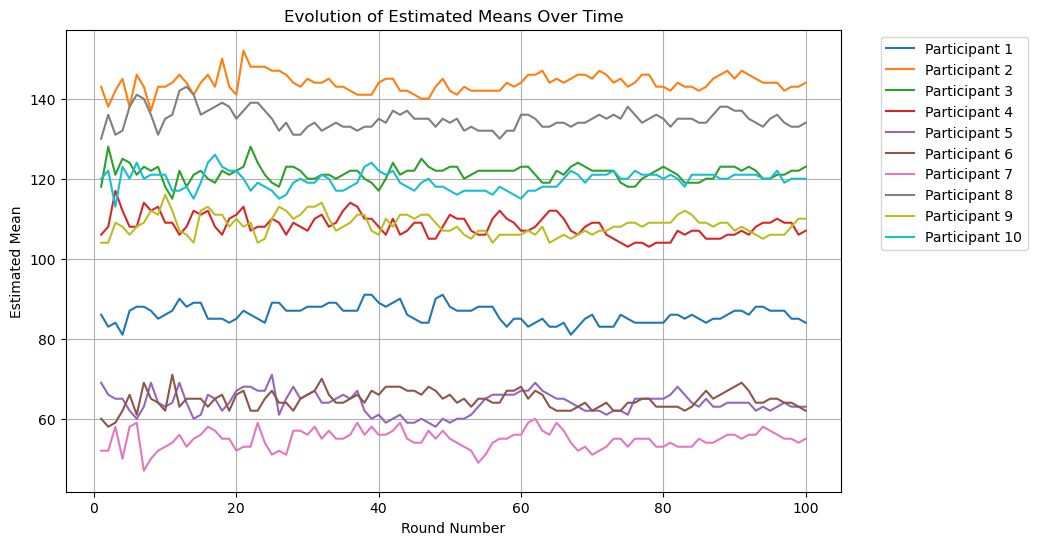

In [1159]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Set the number of participants and parameters for the auction
num_participants = 10
true_means = np.random.uniform(50, 150, num_participants)  # True means of participants
stddevs = np.full(num_participants, 5)  # Standard deviations for each participant
num_rounds = 100 # Number of rounds to simulate

# Initialize the auction
auction = Auction(num_participants, stddevs, true_means)

# Track estimated means over rounds
estimated_means_history = np.zeros((num_rounds, num_participants))

total_true_reserve_profit = 0
total_est_reserve_profit = 0

# Simulate the auction over the specified number of rounds
for round_number in range(1, num_rounds + 1):
    round_results = auction.run_auction(round_number)
    estimated_means_history[round_number - 1] = auction.est_means.copy()
    total_true_reserve_profit += round_results["payment_true"] if round_results["payment_true"] else 0
    total_est_reserve_profit += round_results["payment_estimated"] if round_results["payment_estimated"] else 0

# Print out the total profits over the specified number of rounds
print(f"Total Profit using True Reserve Prices over {num_rounds} rounds: {total_true_reserve_profit}")
print(f"Total Profit using Estimated Reserve Prices over {num_rounds} rounds: {total_est_reserve_profit}")

# Plot estimated means over time
plt.figure(figsize=(10, 6))
for i in range(num_participants):
    plt.plot(range(1, num_rounds + 1), estimated_means_history[:, i], label=f'Participant {i+1}')

plt.xlabel("Round Number")
plt.ylabel("Estimated Mean")
plt.title("Evolution of Estimated Means Over Time")
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid()
plt.show()

In [1160]:
# After the auction ends, print the comparison of true and estimated means for each participant
for i in range(num_participants):
    print(f"Participant {i+1}: True Mean = {auction.true_means[i]}, Estimated Mean = {auction.est_means[i]}")

Participant 1: True Mean = 87.45401188473625, Estimated Mean = 84
Participant 2: True Mean = 145.07143064099162, Estimated Mean = 144
Participant 3: True Mean = 123.1993941811405, Estimated Mean = 123
Participant 4: True Mean = 109.86584841970367, Estimated Mean = 107
Participant 5: True Mean = 65.60186404424365, Estimated Mean = 63
Participant 6: True Mean = 65.59945203362027, Estimated Mean = 62
Participant 7: True Mean = 55.80836121681995, Estimated Mean = 55
Participant 8: True Mean = 136.61761457749353, Estimated Mean = 134
Participant 9: True Mean = 110.11150117432088, Estimated Mean = 110
Participant 10: True Mean = 120.80725777960456, Estimated Mean = 120


In [1161]:
# After the auction ends, print the comparison of true and estimated reserve prices for each participant
for i, data in auction.participants.items():
    print(f"Participant {i+1}: True Reserve Price = {data['true_reserve_price']}, Estimated Reserve Price = {data['Estimated_reserve_price']}")

Participant 1: True Reserve Price = 77.82702917193446, Estimated Reserve Price = 74.48389148215944
Participant 2: True Reserve Price = 134.15087322892364, Estimated Reserve Price = 133.09720438579538
Participant 3: True Reserve Price = 112.67800408478666, Estimated Reserve Price = 112.48264859758564
Participant 4: True Reserve Price = 99.6342731799071, Estimated Reserve Price = 96.83654952060877
Participant 5: True Reserve Price = 56.79570493836255, Estimated Reserve Price = 54.31524576649189
Participant 6: True Reserve Price = 56.7934025369315, Estimated Reserve Price = 53.363670269357996
Participant 7: True Reserve Price = 47.496608820983724, Estimated Reserve Price = 46.73412272041569
Participant 8: True Reserve Price = 125.84183888351781, Estimated Reserve Price = 123.27133035352729
Participant 9: True Reserve Price = 99.87419136028916, Estimated Reserve Price = 99.76529108591075
Participant 10: True Reserve Price = 110.33486965151856, Estimated Reserve Price = 109.54442411498403


In [1162]:
from sklearn.metrics import mean_squared_error

# Example usage
mse = mean_squared_error(auction.true_means, auction.est_means)
print(f"Total Mean Squared Error: {mse:.4f}")

Total Mean Squared Error: 4.9226
